In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import causal_convolution_layer
import Dataloader

In [2]:
import math
from torch.utils.data import DataLoader

In [3]:
class PositionalEncoding(torch.nn.Module):

    def __init__(self, d_model=128, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [4]:
class TransformerTimeSeries(torch.nn.Module):
    def __init__(self):
        super(TransformerTimeSeries,self).__init__()
        self.input_embedding = causal_convolution_layer.context_embedding(2,128,5)
        self.transformer_model = torch.nn.Transformer(nhead=16,num_encoder_layers=12,d_model=128)
        self.positional_embedding = PositionalEncoding(128,.1)
        self.fc1 = torch.nn.Linear(128,1)
        
    def forward(self,x_obs,x_future,y_obs,y_future,attention_masks):
        
        # concatenate observed points and time covariate
        # (B*feature_size*n_time_points)
        z_obs = torch.cat((y_obs.unsqueeze(1),x_obs.unsqueeze(1)),1)
        z_future = torch.cat((y_future.unsqueeze(1),x_future.unsqueeze(1)),1)

        # input_embedding returns shape (B*embedding_size*n_time_points) -> need (n_time_points*B,embedding_size)
        z_obs_embedding = self.input_embedding(z_obs).permute(2,0,1)
        z_future_embedding = self.input_embedding(z_future).permute(2,0,1)
        
        # get my positional embeddings
        positional_embeddings = self.positional_embedding(torch.cat((z_obs_embedding,z_future_embedding),0))
        z_obs_embedding = positional_embeddings[0:z_obs_embedding.shape[0]]#self.positional_embedding(z_obs_embedding)
        z_future_embedding = positional_embeddings[z_obs_embedding.shape[0]:]#self.positional_embedding(z_future_embedding)
        
        transformer_embedding = self.transformer_model(z_obs_embedding,z_future_embedding,tgt_mask=attention_masks)

        output = self.fc1(transformer_embedding.permute(1,0,2))
        
        return output
        

In [5]:
x = torch.randn([1,])

In [6]:
train_dataset = Dataloader.time_series_paper(96,4500)
validation_dataset = Dataloader.time_series_paper(96,500)

x: 4500*120 fx: 4500*120
x: 500*120 fx: 500*120


In [7]:
criterion = torch.nn.MSELoss()

In [8]:
train_dl = DataLoader(train_dataset,batch_size=16,shuffle=True)
validation_dl = DataLoader(validation_dataset,batch_size=64)

In [9]:
model = TransformerTimeSeries().cuda()

In [10]:
lr = .00005 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,10, gamma=0.5)

In [11]:
epochs = 25

In [12]:
train_epoch_loss = []
eval_epoch_loss = []
for e,epoch in enumerate(range(epochs)):
    train_loss = []
    eval_loss = []
    
    model.train()
    for step,(x_obs,x_future,y_obs,y_future,attention_masks) in enumerate(train_dl):
        optimizer.zero_grad()
        output = model(x_obs.cuda(),x_future.cuda(),y_obs.cuda(),y_future.cuda(),attention_masks[0].cuda())
        loss = criterion(output.squeeze()[:,:-1],y_future.cuda()[:,1:])
        train_loss.append(loss)
        
        loss.backward()
        optimizer.step()
        
    model.eval()
    with torch.no_grad():
        for step,(x_obs,x_future,y_obs,y_future,attention_masks) in enumerate(validation_dl):
            output = model(x_obs.cuda(),x_future.cuda(),y_obs.cuda(),y_future.cuda(),attention_masks[0].cuda())
            loss = criterion(output.squeeze()[:,:-1],y_future.cuda()[:,1:])
            eval_loss.append(loss)
        
    
    with torch.no_grad():
        train_loss = np.sum(train_loss)/len(train_dl)
        eval_loss = np.sum(eval_loss)/len(validation_dl)
        print("Epoch {}: Train loss-{} \t Validation loss-{}".format(e,
                                                                     train_loss,
                                                                     eval_loss))
        train_epoch_loss.append(train_loss)
        eval_epoch_loss.append(eval_loss)
        
    scheduler.step()

C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\torch\nn\functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 0: Train loss-1474.6141357421875 	 Validation loss-891.3351440429688
Epoch 1: Train loss-363.3630676269531 	 Validation loss-60.45608901977539
Epoch 2: Train loss-64.41789245605469 	 Validation loss-181.1331787109375
Epoch 3: Train loss-39.070884704589844 	 Validation loss-34.39649963378906
Epoch 4: Train loss-30.034421920776367 	 Validation loss-28.637479782104492
Epoch 5: Train loss-24.741422653198242 	 Validation loss-14.703786849975586
Epoch 6: Train loss-20.922061920166016 	 Validation loss-25.033103942871094
Epoch 7: Train loss-19.92946434020996 	 Validation loss-9.672934532165527
Epoch 8: Train loss-16.946748733520508 	 Validation loss-10.165197372436523
Epoch 9: Train loss-16.089885711669922 	 Validation loss-13.040546417236328
Epoch 10: Train loss-12.02191162109375 	 Validation loss-14.311769485473633
Epoch 11: Train loss-11.57772159576416 	 Validation loss-18.51439666748047
Epoch 12: Train loss-11.296610832214355 	 Validation loss-15.081673622131348
Epoch 13: Train loss

## Visualize the data

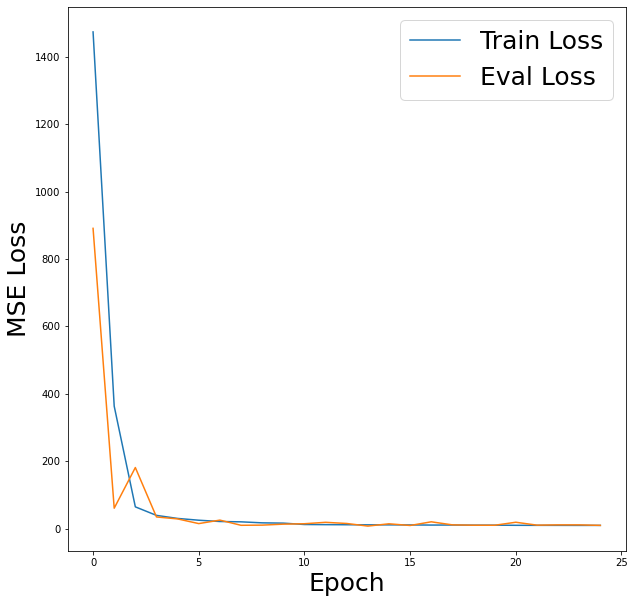

In [21]:
plt.figure(figsize=(10,10))
plt.plot(train_epoch_loss)
plt.plot(eval_epoch_loss)
plt.legend(['Train Loss','Eval Loss'],fontsize=25)
plt.xlabel("Epoch",fontsize=25)
plt.ylabel("MSE Loss",fontsize=25)
plt.show()

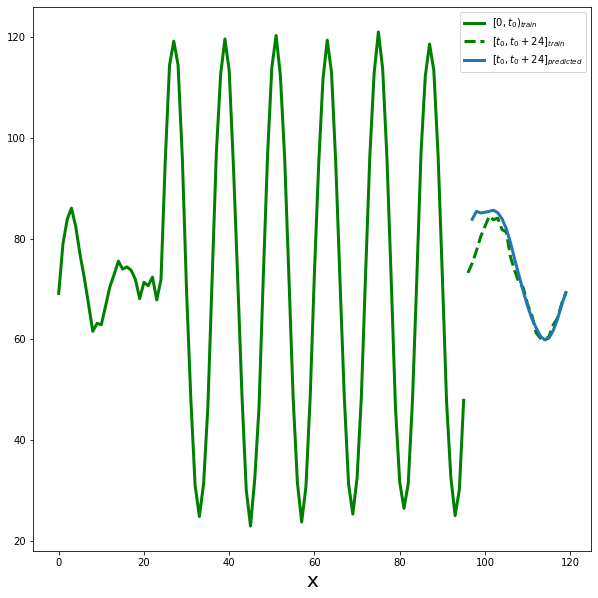

C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\torch\nn\functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


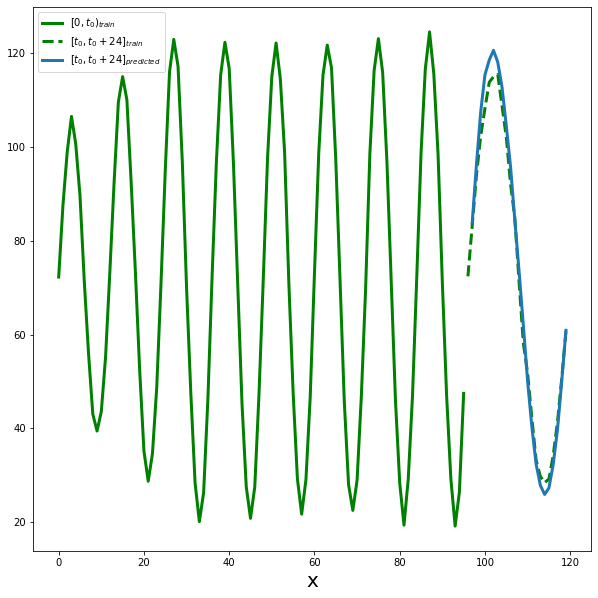

C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\torch\nn\functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


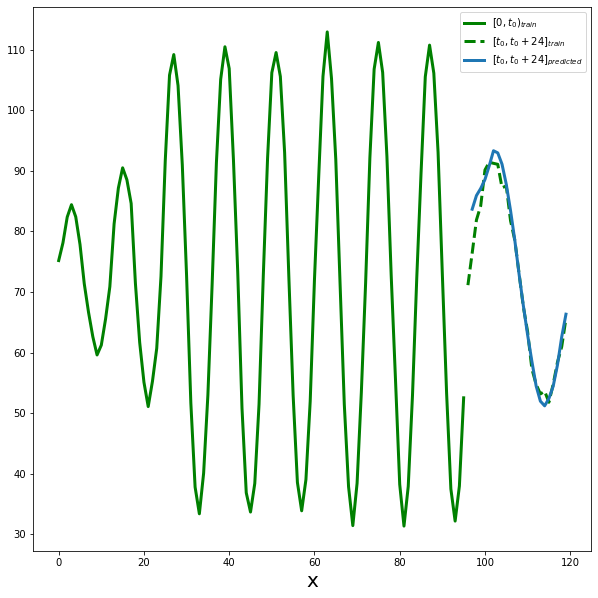

C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\torch\nn\functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


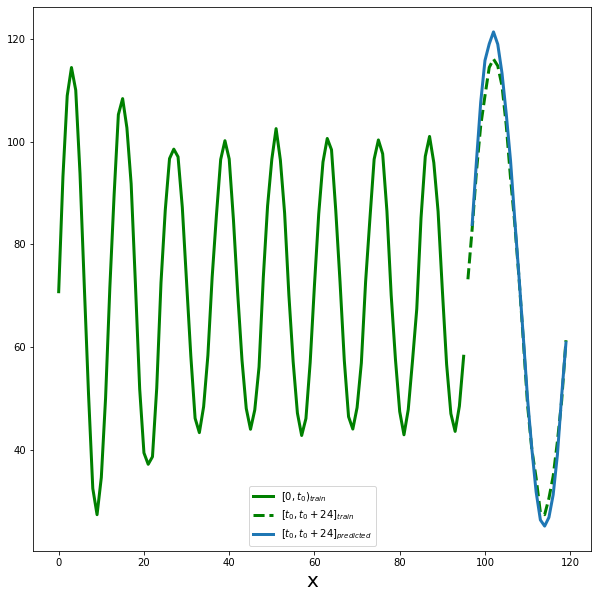

C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\torch\nn\functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


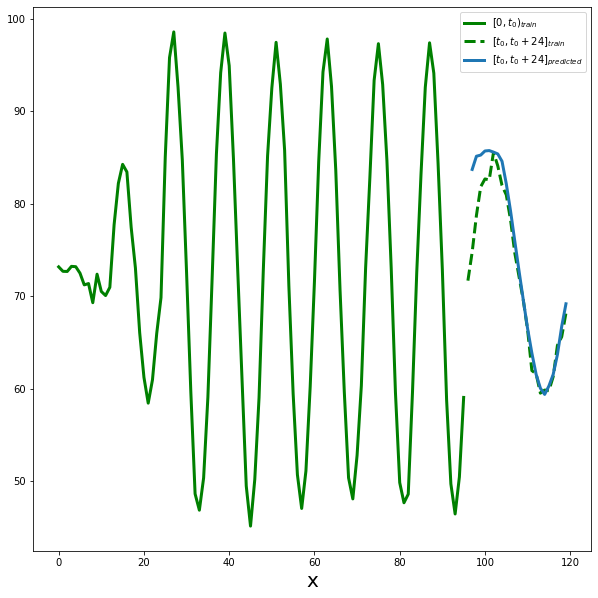

C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\torch\nn\functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


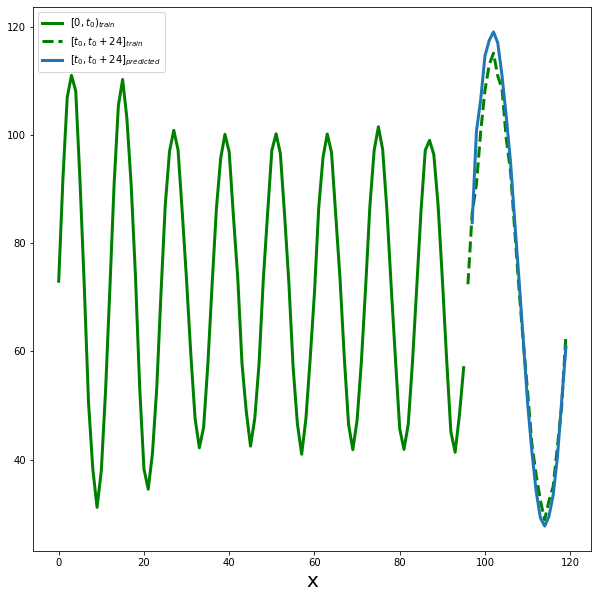

C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\torch\nn\functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [33]:
n_plots = 5
with torch.no_grad():
    model.eval()
    for step,(x_obs,x_future,y_obs,y_future,attention_masks) in enumerate(validation_dl):
            output = model(x_obs.cuda(),x_future.cuda(),y_obs.cuda(),y_future.cuda(),attention_masks[0].cuda())

            if step > n_plots:
                break

            with torch.no_grad():
                plt.figure(figsize=(10,10))
                plt.plot(x_obs[0].cpu().detach().squeeze().numpy(),y_obs[0].cpu().detach().squeeze().numpy(),'g-',linewidth=3)
                plt.plot(x_future[0].cpu().detach().squeeze().numpy(),y_future[0].cpu().detach().squeeze().numpy(),'g--',linewidth=3)

                plt.plot(x_future[0].cpu().detach().squeeze().numpy()[1:],output[0].cpu().detach().squeeze().numpy()[:-1],linewidth=3)
                plt.xlabel("x",fontsize=20)
                plt.legend(["$[0,t_0)_{train}$","$[t_0,t_0+24]_{train}$","$[t_0,t_0+24]_{predicted}$"])
                plt.show()
